In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
OBJECT_DETECTION_WEIGHTS = (
    "/runai-ivrl-scratch/students/2021-fall-sp-jellouli/output/model_final.pth"
)
NYU_V2_TEST_PATH = "/runai-ivrl-scratch/students/2021-fall-sp-jellouli/zero_shot_datasets/NYU/nyu_depth_v2_labeled.mat"
SPLIT_PATH = "/runai-ivrl-scratch/students/2021-fall-sp-jellouli/zero_shot_datasets/NYU/splits.mat"
MIDAS_HKRM_WEIGHTS_PATH = "/runai-ivrl-scratch/students/2021-fall-sp-jellouli/output_midas_hkrm/"
DEVICE = "cuda"
DEBUG = False

In [3]:
import os, sys
import glob
sys.path.append(os.path.normpath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.normpath(os.path.join(os.getcwd(), '..', 'external', 'MiDaS')))
import matplotlib.pyplot as plt
from midas_hkrm.utils import construct_config
from midas_hkrm.zero_shot import NyuV2Evaluator, ETH3DEvaluator, DIWEvaluator
from midas_hkrm.utils import midas_test_transform, read_image
import logging
import sys
from midas.midas_net import MidasNet
import torch
from midas_hkrm.datasets import ApolloScape, TartanAir, RedWeb, BlendedMVS, MegaDepth, HRWSI
from midas_hkrm.depth import MidasHKRMNet
from midas_hkrm.utils import midas_train_transform, midas_eval_transform, construct_config
from midas_hkrm.objects import GeneralizedRCNNObjectDetector
from midas_hkrm.optim import SSITrimmedMAELoss
import numpy as np 

In [4]:
%env ZERO_SHOT_DATASETS=/runai-ivrl-scratch/students/2021-fall-sp-jellouli/zero_shot_datasets

env: ZERO_SHOT_DATASETS=/runai-ivrl-scratch/students/2021-fall-sp-jellouli/zero_shot_datasets


In [5]:
import logging
logger = logging.getLogger(__name__)
level = logging.DEBUG if DEBUG else logging.INFO
logging.basicConfig(stream=sys.stdout, level=level)

In [378]:
logger.info("Constructing Object detection network")
cfg = construct_config()
cfg.MODEL.WEIGHTS = OBJECT_DETECTION_WEIGHTS
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (
    0.4  # Higher threshold for more precise object detection
)
object_detector = GeneralizedRCNNObjectDetector(cfg)

logger.info("Preparing modified midas network")
model = MidasHKRMNet(
    object_detector, max_objects=20, device=DEVICE, pretrained_resnet=True
)

INFO:__main__:Constructing Object detection network
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /runai-ivrl-scratch/students/2021-fall-sp-jellouli/output/model_final.pth ...
INFO:__main__:Preparing modified midas network


Using cache found in /runai-ivrl-scratch/students/2021-fall-sp-jellouli/.cache/torch/hub/facebookresearch_WSL-Images_main


In [379]:
import re
iter_extractor = r"state_(?P<iteration>([0-9]*)).tar"

In [ ]:
res = {}
for state in glob.glob(os.path.join(MIDAS_HKRM_WEIGHTS_PATH, '*.tar')):
    iter_num = int(re.fullmatch(iter_extractor, os.path.basename(state))['iteration'])
    logger.info(f"Testing state {iter_num}")
    state = torch.load(state)["model"]
    model.load_state_dict(state)

    evaluator = NyuV2Evaluator(
        path=NYU_V2_TEST_PATH,
        split_path=SPLIT_PATH,
        model=model,
        transform=midas_test_transform,
        device=DEVICE,
        pass_input=True,
    )
    
    res[iter_num] = evaluator.evaluate()

INFO:__main__:Testing state 230000
INFO:midas_hkrm.zero_shot.evaluator:Evaluating Bad pixel metric > 1.25 (with depth capped at 10) on NYU_V2 and model MidasHKRMNet


33it [00:18,  1.77it/s]

In [ ]:
for k,v in res.items():
    res[k] = float(v)

In [58]:
ordered_res = OrderedDict(sorted(res.items()))

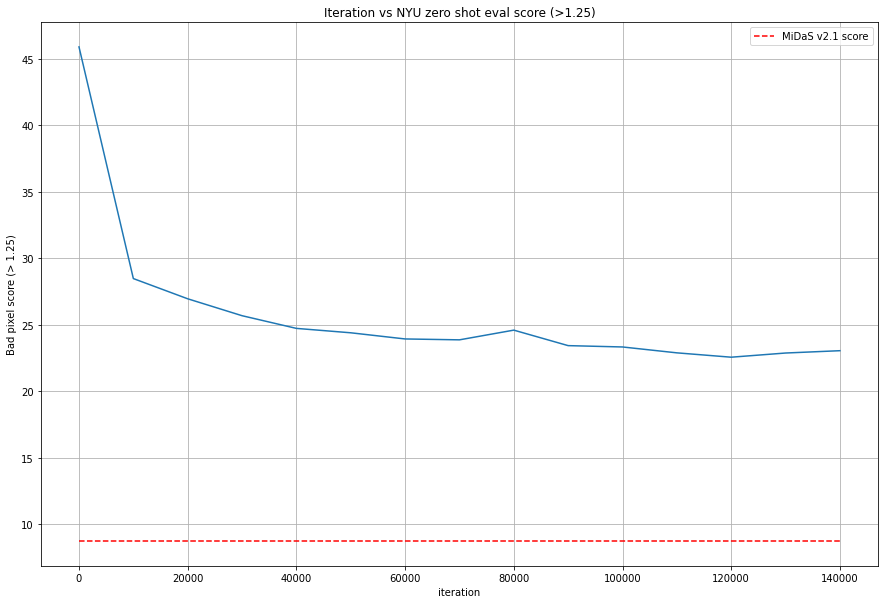

In [72]:
plt.figure(figsize=(15,10))
plt.plot(ordered_res.keys(), ordered_res.values())
plt.title("Iteration vs NYU zero shot eval score (>1.25)")
plt.xlabel("iteration")
plt.ylabel("Bad pixel score (> 1.25)")
plt.hlines(y=8.73, linestyles='dashed', xmin=0, xmax=140000, label='MiDaS v2.1 score', colors='red')
plt.grid(True)
plt.legend()
plt.savefig('nyu.jpg', bbox_inches='tight', dpi=150)
plt.show()

In [1]:
from functools import reduce
from operator import add

In [2]:
reduce(add, [1,2,3])

6

In [6]:
import pickle
with open('../res_1_model.pickle', 'rb') as handle:
    res_1 = pickle.load(handle)

In [7]:
import pickle
with open('../res_2_model.pickle', 'rb') as handle:
    res_2 = pickle.load(handle)

In [8]:
res_1

{'state_0.tar': tensor(21.3776, device='cuda:0'),
 'state_39999.tar': tensor(99.3578, device='cuda:0'),
 'state_9999.tar': tensor(99.3578, device='cuda:0'),
 'state_79999.tar': tensor(99.3578, device='cuda:0'),
 'state_49999.tar': tensor(99.3578, device='cuda:0'),
 'state_59999.tar': tensor(99.3578, device='cuda:0'),
 'state_19999.tar': tensor(99.3578, device='cuda:0'),
 'state_29999.tar': tensor(99.3578, device='cuda:0'),
 'state_69999.tar': tensor(99.3578, device='cuda:0')}

In [9]:
res_2

{'state_0.tar': tensor(51.0856, device='cuda:0'),
 'state_39999.tar': tensor(99.3578, device='cuda:0'),
 'state_9999.tar': tensor(99.3578, device='cuda:0'),
 'state_49999.tar': tensor(99.3578, device='cuda:0'),
 'state_59999.tar': tensor(99.3578, device='cuda:0'),
 'state_19999.tar': tensor(99.3578, device='cuda:0'),
 'state_29999.tar': tensor(99.3578, device='cuda:0'),
 'state_69999.tar': tensor(99.3578, device='cuda:0')}

## ETH3D